Use SocialGNN_encoding_2 conda environment

To facilitate graph creation andnhelp standardize graph size, we only kept clips with at least 2 people and a maximum of 5 entities (people + objects)

 node features were obtained by passing pixel information within that entity’s bounding box through a pretrained VGG19 network30. The output from the penultimate fully connected layer was reduced to 20 dimensions via PCA and this feature vector was appended with the 4D coordinates of the bounding box (representing the location and size of the entity) and a boolean variable denoting whether it was an agent (person) or an object. 

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import tensorflow as tf
import pynvml
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Check if TensorFlow is using the GPU
if tf.test.is_gpu_available():
    print("TensorFlow is using the GPU")
    
    # Initialize the pynvml library
    pynvml.nvmlInit()
    
    # Get the number of GPU devices
    num_gpus = pynvml.nvmlDeviceGetCount()
    
    # Iterate over GPU devices
    for i in range(num_gpus):
        # Get the device identifier
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        # Get the full GPU name
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)
        
    # Shutdown the pynvml library
    pynvml.nvmlShutdown()
else:
    print("TensorFlow is not using the GPU")

TensorFlow is using the GPU
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
video_input_path = 'Data/dyad_videos_3000ms'
annotation_input_path = 'Data/preprocess/annotations.csv'
patches_output_path = 'Data/preprocess/video_data/'
pca_dir = "Data/preprocess/fitted_PCA"

In [4]:
def load_pickle(path):
    with open(path, 'rb') as f:
        pickled = pickle.load(f)
    return pickled

In [5]:
def save_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

## CROP OUT IMAGES PATCHES FROM VIDEOS

In [6]:
annotations = pd.read_csv(annotation_input_path)
annotations

,video_name,frame,label_name,left,top,right,bottom,gaze_direction
0,-YwZOeyAQC8_15.mp4,1,head1,0,101,94,228,"head1, neither"
1,-YwZOeyAQC8_15.mp4,1,head2,86,211,155,286,"head2, object1"
2,-YwZOeyAQC8_15.mp4,1,object1,189,279,243,327,NaN
3,-YwZOeyAQC8_15.mp4,2,head1,0,101,93,225,"head1, neither"
4,-YwZOeyAQC8_15.mp4,2,head2,86,211,154,285,"head2, object1"
...,...,...,...,...,...,...,...,...
59879,yt-k6Ildfvd4wA_76.mp4,88,head2,363,5,500,262,"head2, head1"
59880,yt-k6Ildfvd4wA_76.mp4,89,head1,0,68,68,290,"head1, head2"
59881,yt-k6Ildfvd4wA_76.mp4,89,head2,363,5,500,262,"head2, head1"
59882,yt-k6Ildfvd4wA_76.mp4,90,head1,0,68,68,290,"head1, head2"


In [7]:
# Iterate over each unique video in the DataFrame
for video_name in tqdm(annotations['video_name'].unique()):
    # print("Processing video:", video_name)
    # Fetch all frames annotations in this video
    save_path = os.path.join(patches_output_path, video_name)
    os.makedirs(save_path, exist_ok=True)
    video = cv2.VideoCapture(os.path.join(video_input_path, video_name))
    video_annotations = annotations[annotations['video_name'] == video_name]
    patches = []
    annotations_dict = {'labels': [], 'gazes': [], 'frame_numbers': [], 
                   'left': [], 'right': [], 'top': [], 'bottom': []}
    
    for current_frame in range(1, 91):
        successful_read, frame = video.read()
        if successful_read:
            # Filter annotations for the current frame
            frame_annotations = video_annotations[video_annotations['frame'] == current_frame]
            if not frame_annotations.empty:
                for _, entity in frame_annotations.iterrows():
                    patches.append(frame[int(entity['top']):int(entity['bottom']),int(entity['left']):int(entity['right'])])
                    annotations_dict['labels'].append(entity['label_name'])
                    annotations_dict['gazes'].append(entity['gaze_direction'])   
                    annotations_dict['frame_numbers'].append(current_frame)
                    annotations_dict['left'].append(int(entity['left']))
                    annotations_dict['right'].append(int(entity['right']))
                    annotations_dict['top'].append(int(entity['top']))
                    annotations_dict['bottom'].append(int(entity['bottom']))
                    
        else:
            raise ValueError(f"Unsuccessful read frame {current_frame} of {video_name}")
    save_pickle(patches, os.path.join(save_path, 'patches'))
    annotation_df = pd.DataFrame(annotations_dict)
    save_pickle(annotation_df, os.path.join(save_path, 'annotations'))


100%|██████████| 250/250 [00:33<00:00,  7.54it/s]


In [8]:
def visualize_patches(num_patches_to_display=10):
    # Get a list of all subdirectories in the patches_output_path directory
    videos = [d for d in os.listdir(patches_output_path)]
    import random
    # Randomly select one of the subdirectories
    selected_subdir = random.choice(videos)
    selected_path = os.path.join(patches_output_path, selected_subdir)
    
    patches = load_pickle(os.path.join(selected_path, 'patches'))
    annot = load_pickle(os.path.join(selected_path, 'annotations'))
    
    # Display each patch with its corresponding labels
    print(len(patches))
    for i, patch in enumerate(patches):
        print(annot.loc[i, 'frame_numbers'])
        print(annot.loc[i, 'labels'])
        print(annot.loc[i, 'gazes'])
        plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        if i+2> num_patches_to_display:
            break


270
1
head1
head1, object1


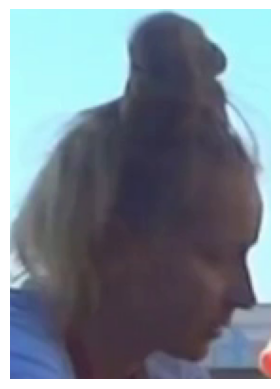

1
head2
head2, object1


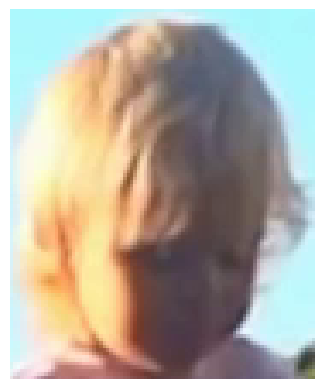

1
object1
nan


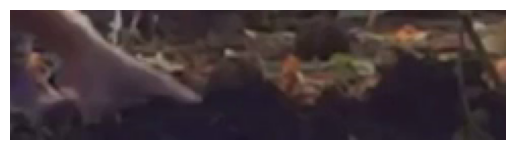

2
head1
head1, object1


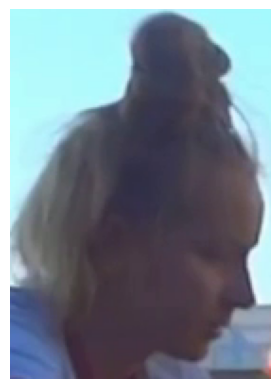

2
head2
head2, object1


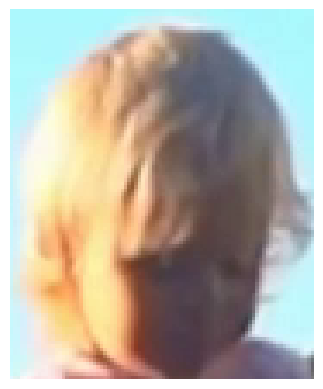

In [9]:
visualize_patches(5)

## VGG FEATURES

In [10]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.models import Model

In [11]:
def reshape_patches(x):
    temp = np.expand_dims(x, axis=0)
    temp2 = preprocess_input(smart_resize(temp, (224,224)))
    return temp2[0]

In [12]:
base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [13]:
restart = input('Do you want to reprocess the input videos? (y/n)')

In [ ]:
for video in tqdm(os.listdir(patches_output_path)):
    video_dir = os.path.join(patches_output_path, video)
    patch_dir = os.path.join(video_dir, "patches")
    out_dir = os.path.join(video_dir, "VGG19_patches")
    if not os.path.exists(out_dir) or restart == 'y':
        patches = load_pickle(patch_dir)
        reshaped_patches  = [reshape_patches(patch) for patch in patches]
        x = np.array(reshaped_patches)
        y = model.predict(x)
        save_pickle(y, out_dir)
        print(f"VGG19 patches saved to {video_dir}")


In [25]:
print(x.shape)

(270, 224, 224, 3)


In [24]:
print(y.shape)

(270, 4096)


## fit PCA

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [16]:
def extract_all_vggfeatures():
    all_features = []
    for video in tqdm(os.listdir(patches_output_path)):
        patch_dir = os.path.join(patches_output_path, video, "VGG19_patches") 
        all_features.extend(load_pickle(patch_dir))
        
    all_features = np.array(all_features)
    print(all_features.shape)
    return all_features

In [17]:
def fit_pca(all_features):
    pca = PCA(n_components=20)
    scaler = StandardScaler()
    all_features_scaled = scaler.fit_transform(all_features)
    pca.fit(all_features_scaled)
    return pca, scaler

In [18]:

pca, scaler = fit_pca(extract_all_vggfeatures())
save_pickle(pca, os.path.join(pca_dir, "pca"))
save_pickle(scaler, os.path.join(pca_dir, "scaler"))

100%|██████████| 250/250 [00:02<00:00, 114.99it/s]


(59884, 4096)


## PCA on VGG features

In [19]:
pca = load_pickle(os.path.join(pca_dir, "pca"))
scaler = load_pickle(os.path.join(pca_dir, 'scaler'))

In [20]:
for video in tqdm(os.listdir(patches_output_path)):
    video_dir = os.path.join(patches_output_path, video)
    patch_dir = os.path.join(video_dir, "VGG19_patches")
    vgg_features = load_pickle(patch_dir)
    scaled_features = scaler.transform(vgg_features)
    pca_features = pca.transform(scaled_features)
    save_pickle(pca_features, os.path.join(video_dir, "pca_features"))    

100%|██████████| 250/250 [00:02<00:00, 98.03it/s] 


## Node Features


In [21]:
for video in tqdm(os.listdir(patches_output_path)):
    video_dir = os.path.join(patches_output_path, video)
    pca_features = load_pickle(os.path.join(video_dir, "pca_features"))
    video_annot = load_pickle(os.path.join(video_dir, "annotations"))
    new_features = []
    for i, patch_feature in enumerate(pca_features):
        new_feature = np.append(patch_feature, [video_annot['top'][i], video_annot['bottom'][i], video_annot['left'][i], video_annot['right'][i]])
        new_feature = np.append(new_feature, [0] if video_annot['labels'][i] in ['head1', 'head2'] else [1])
        assert len(new_feature) == 25
        new_features.append(new_feature)
    video_annot['features'] = new_features
    save_pickle(video_annot, os.path.join(video_dir, "annotations"))

100%|██████████| 250/250 [00:04<00:00, 51.44it/s]


## Build Graph

In [22]:
all_videos = []
all_labels = ['head1', 'head2', 'object1', 'object2', 'placeholder']
for video_name in tqdm(sorted(os.listdir(patches_output_path))):
    video_dict = {'label':[], 'graph_dicts':[], 'video_name': video_name} ## label here refers to the event attribute (not used)
    video_dir = os.path.join(patches_output_path, video_name)
    annotations = load_pickle(os.path.join(video_dir, "annotations"))
    
    grouped = annotations.groupby('frame_numbers')

    for frame_number, group in grouped:
        edges = group['gazes']
        senders = []
        receivers = []
        nodes = []
        # Process in the order of the all_labels list
        for i, label in enumerate(all_labels):                
            # if the entity exists
            if (annotations['labels'] == label).any():
                # Access the value in the 'features' and 'gazes' columns of that entity
                feature = annotations.loc[annotations['labels'] == label, 'features'].iloc[0]
                nodes.append(feature.tolist())
                edge = annotations.loc[annotations['labels'] == label, 'gazes'].iloc[0]
                # if gaze exists (only when the entity is head1 or head2)
                if not isinstance(edge, float):
                    sender, receiver = edge.split(', ')
                    # if the gaze is at some entities not found in the video, the gaze will be discarded
                    if sender == label and receiver != "neither" and receiver in all_labels: 
                        senders.append(i)
                        receivers.append(all_labels.index(receiver))
            else:
                # Pad the nodes if there are missing feature/less than 5 features
                nodes.append([0 for j in range(25)])

        assert len(nodes) == 5

        graph_dict = {'nodes': nodes, 'senders': senders, 'receivers': receivers}
        video_dict['graph_dicts'].append(graph_dict)
        
    all_videos.append(video_dict)

100%|██████████| 250/250 [00:31<00:00,  7.87it/s]


In [23]:
save_pickle(all_videos, "Data/preprocess/graphs")

In [34]:
all_videos[0]['graph_dicts'][0]['receivers']

[2]

dictionary structure:
 video index(keys) --> sequences (index) --> frames (index) --> nodes & senders & receivers
 
    ## outer loops: video --> multiple sequences --> multiple frames
    ## Under one frame: feature numbers, senders and reveicers in all edges.
    print(len(V[key]['graph_dicts'][0][0]['nodes']), len(V[key]['graph_dicts'][0][0]['senders']), len(V[key]['graph_dicts'][0][0]['receivers']))
    ## number of frames in a sequence
    print(len(V[key]['graph_dicts'][0]))
    ## number of sequences in a video
    print(len(V[key]['graph_dicts']))
    
  
I guess let me try not to divide the sequences first
so I would have 

video index (keys) --> frames(index) --> nodes & senders & receivers

I also didn't do bootstrapping